In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import regionmask
import pandas as pd
import xesmf as xe


Bad key "text.kerning_factor" on line 4 in
/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Import our data

#### Import GC output

In [7]:
GC_new = xr.open_dataset('../../GCrundirs/test_NEI_jan_CNO2/geosfp_4x5_standard/OutputDir/GEOSChem.SpeciesConc.20160101_0000z.nc4') #dataset with the kgC/m2/s and kgNO2/m2/s
GC_orig = xr.open_dataset('../../GCrundirs/test_NEI_jan_orig2011NEI/geosfp_4x5_standard/output_2013/GEOSChem.SpeciesConc.20160101_0000z.nc4') #2013 scaled NEI

datasets = [GC_new,
            GC_orig]

#combine the two datasets
GC_ds = xr.concat(datasets, pd.Index(['new','orig'], name='name')) #concat our two datasets
GC_ds*=1e9 #convert to ppb

#sum our NO and NO2
GC_ds['NOx'] = GC_ds['SpeciesConc_NO'] + GC_ds['SpeciesConc_NO2']

#### Import HEMCO diagnostics

In [8]:
HEMCO_new = xr.open_dataset('../../GCrundirs/test_NEI_jan_CNO2/geosfp_4x5_standard/OutputDir/HEMCO_diagnostics.201601010000.nc')
HEMCO_old = xr.open_dataset('../../GCrundirs/test_NEI_jan_orig2011NEI/geosfp_4x5_standard/output_2013/HEMCO_diagnostics.201601010000.nc')

datasets = [HEMCO_new,
           HEMCO_old]

#combine the two datasets
HEMCO_ds = xr.concat(datasets, pd.Index(['new','orig'], name='name')) #concat our two datasets

#sum our NO and NO2
#HEMCO_ds['NOx'] = HEMCO_ds['EmisNO_Total'] + HEMCO_ds['EmisNO2_Anthro']

## Plot the NOx for each GC run

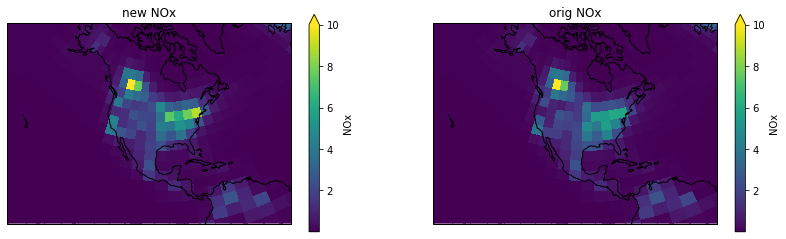

In [9]:
#### plot our NO2 for each dataset ####

fig, axes = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.LambertConformal()})

for idx, nm in enumerate(GC_ds['name'].values):
    ax = axes[idx]
    GC_ds['NOx'].isel(lev = 0).sel(name = nm).plot(ax=ax, #set the axis
                                       extend='max',#extend the colorbar in both directions
                                       transform=ccrs.PlateCarree(), #fit data into map
                                        cmap='viridis',
                                        vmax = 10)
    ax.coastlines()
    ax.set_extent([-150, -50, 0, 70])
    ax.set_title(f'{nm} NOx')


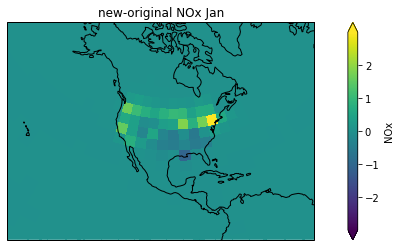

In [10]:
#### plot the difference in NO2 for our original and new files ####

fig, ax = plt.subplots(figsize = [12,4], subplot_kw={'projection':ccrs.LambertConformal()})
(GC_ds['NOx'].isel(lev = 0).sel(name = 'new') - 
 GC_ds['NOx'].isel(lev = 0).sel(name = 'orig')).plot(ax=ax, #set the axis
                                   extend='both',#extend the colorbar in both directions
                                   transform=ccrs.PlateCarree(), #fit data into map
                                    cmap='viridis'
                                   )
ax.coastlines()
ax.set_extent([-150, -50, 0, 70])
ax.set_title(f'{nm} NOx');
plt.title('new-original NOx Jan');


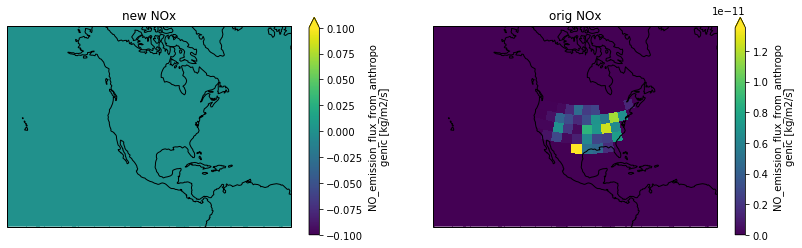

In [11]:
#### plot our NOx of HEMCO Emissions ####

fig, axes = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.LambertConformal()})

for idx, nm in enumerate(GC_ds['name'].values):
    ax = axes[idx]
    HEMCO_ds['EmisNO_Anthro'].isel(lev = 1).sel(name = nm).plot(ax=ax, #set the axis
                                       extend='max',#extend the colorbar in both directions
                                       transform=ccrs.PlateCarree(), #fit data into map
                                        cmap='viridis')
    ax.coastlines()
    ax.set_extent([-150, -50, 0, 70])
    ax.set_title(f'{nm} NOx')


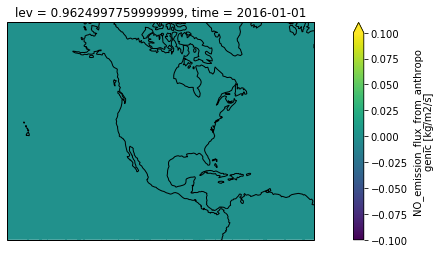

In [12]:
fig, ax = plt.subplots(1,1, figsize = [14,4], subplot_kw={'projection':ccrs.LambertConformal()})
HEMCO_new['EmisNO_Anthro'].isel(lev = 2).plot(ax=ax, #set the axis
                                   extend='max',#extend the colorbar in both directions
                                   transform=ccrs.PlateCarree(), #fit data into map
                                    cmap='viridis')
ax.coastlines()
ax.set_extent([-150, -50, 0, 70])


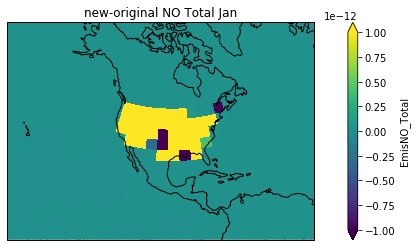

In [13]:
#### plot the difference in NO2 for our original and new files HEMCO ####

fig, ax = plt.subplots(figsize = [12,4], subplot_kw={'projection':ccrs.LambertConformal()})
(HEMCO_ds['EmisNO_Total'].isel(lev = 0).sel(name = 'new') - 
 HEMCO_ds['EmisNO_Total'].isel(lev = 0).sel(name = 'orig')).plot(ax=ax, #set the axis
                                   extend='both',#extend the colorbar in both directions
                                   transform=ccrs.PlateCarree(), #fit data into map
                                    cmap='viridis',
                                   vmax = 1e-12)
ax.coastlines()
ax.set_extent([-150, -50, 0, 70])
ax.set_title(f'{nm} NOx');
plt.title('new-original NO Total Jan');


## Mask our datasets to just the contiguous US

In [13]:
#### import our mask ####
mask = xr.open_dataset('../../masks/USA_mask.geos.1x1.nc')

In [14]:
#### create regridder (reusing weights) to regrid our mask to 4x5 resolution ####
regridder = xe.Regridder(mask, HEMCO_ds, 'bilinear', reuse_weights = True)
regridder  # print basic regridder information.

#### regrid ####
regrid_mask = regridder(mask)
regrid_mask = regrid_mask.drop('time')

Reuse existing file: bilinear_181x360_46x72.nc
using dimensions ('lat', 'lon') from data variable MASK as the horizontal dimensions for this dataset.


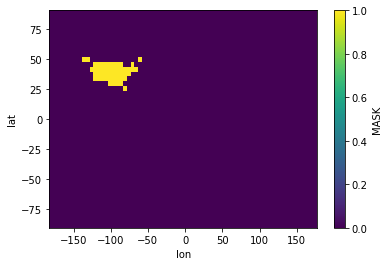

In [15]:
### plot our mask ####
regrid_mask['MASK'].plot()

In [16]:
#GC_US_ds = GC_ds.where(regrid_mask['MASK'] == 1)
HEMCO_US_ds = HEMCO_ds.where(regrid_mask['MASK'] ==1)

NameError: name 'GC_US_ds' is not defined

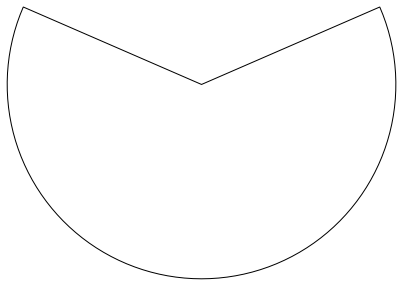

In [17]:
#### plot the difference in NO2 for our original and new files ####

fig, ax = plt.subplots(figsize = [12,5], subplot_kw={'projection':ccrs.LambertConformal()})
(GC_US_ds['NOx'].isel(lev = 0).sel(name = 'new') - 
 GC_US_ds['NOx'].isel(lev = 0).sel(name = 'orig')).plot(ax=ax, #set the axis
                                   extend='both',#extend the colorbar in both directions
                                   transform=ccrs.PlateCarree(), #fit data into map
                                    cmap='viridis')
ax.coastlines()
ax.set_extent([-150, -50, 0, 70])
ax.set_title(f'{nm} NOx Concentration (ppb)');

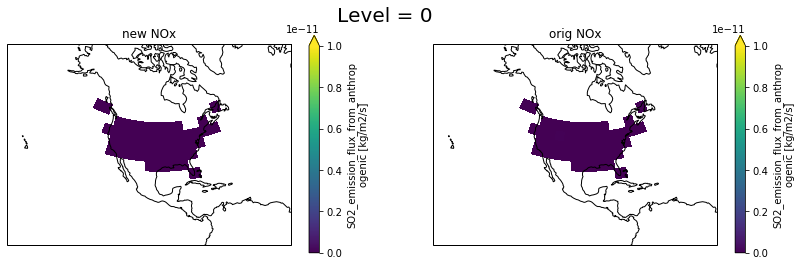

In [24]:
#### plot our NOx of HEMCO Emissions ####

fig, axes = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.LambertConformal()})

for idx, nm in enumerate(GC_ds['name'].values):
    ax = axes[idx]
    HEMCO_US_ds['EmisSO2_Anthro'].isel(lev = 3).sel(name = nm).plot(ax=ax, #set the axis
                                       extend='max',#extend the colorbar in both directions
                                       transform=ccrs.PlateCarree(), #fit data into map
                                        cmap='viridis',
                                        vmax = 1e-11)
    ax.coastlines()
    ax.set_extent([-150, -50, 0, 70])
    ax.set_title(f'{nm} NOx')
plt.suptitle('Level = 0', fontsize = 20);


#### NO2 concentrations in our GEOS Chem output

In [47]:
lev = 2
NOx_conc_orig = (GC_US_ds['NOx'].sel(name = 'orig').isel(lev = lev)).mean().values.item()
NOx_conc_new = (GC_US_ds['NOx'].sel(name = 'new').isel(lev = lev)).mean().values.item()

print('new mean', NOx_conc_new, 'ppb')
print('original mean', NOx_conc_orig, 'ppb')

NameError: name 'GC_US_ds' is not defined

#### NO2 concentrations in our HEMCO diagnostics output

In [48]:
m2_s = HEMCO_US_ds['AREA'] * 60 * 60 * 24 * 31
no_no2 = 30/46
NOx_avgrate_orig = (HEMCO_US_ds['EmisNO_Anthro'].sel(name = 'orig').sum(dim = 'lev') +
                HEMCO_US_ds['EmisNO_BioBurn'].sel(name = 'orig') +
                HEMCO_US_ds['EmisNO2_Anthro'].sel(name = 'orig').sum(dim = 'lev') #+
                ).mean().values.item()

NOx_avgrate_new = (HEMCO_US_ds['EmisNO_Anthro'].sel(name = 'new').sum(dim = 'lev') +
                HEMCO_US_ds['EmisNO_BioBurn'].sel(name = 'new') +
                HEMCO_US_ds['EmisNO2_Anthro'].sel(name = 'new').sum(dim = 'lev') #+
               ).mean().values.item()

print(NOx_avgrate_new, 'kg NOx/m2/s from new NEI')
print(NOx_avgrate_orig, 'kg NOx/m2/s from old NEI')


2.468228052499022e-11 kg NOx/m2/s from new NEI
2.5476940002100434e-11 kg NOx/m2/s from old NEI


In [51]:
lev = 0

NOx_avgrate_orig = (HEMCO_US_ds['EmisNO_Anthro'].sel(name = 'orig').isel(lev = lev) +
                #HEMCO_US_ds['EmisNO_BioBurn'].sel(name = 'orig') +
                HEMCO_US_ds['EmisNO2_Anthro'].sel(name = 'orig').isel(lev = lev) #+
                ).mean().values.item()

NOx_avgrate_new = (HEMCO_US_ds['EmisNO_Anthro'].sel(name = 'new').isel(lev = lev) +
                #HEMCO_US_ds['EmisNO_BioBurn'].sel(name = 'new') +
                HEMCO_US_ds['EmisNO2_Anthro'].sel(name = 'new').isel(lev = lev) #+
               ).mean().values.item()

print(NOx_avgrate_new, 'kg NOx/m2/s from new NEI')
print(NOx_avgrate_orig, 'kg NOx/m2/s from old NEI')


2.465078662028386e-11 kg NOx/m2/s from new NEI
2.073317732775859e-11 kg NOx/m2/s from old NEI


In [131]:
m2_s = HEMCO_US_ds['AREA'] * 60 * 60 * 24 * 31
no2_no = 46.0055/30.01
n_no2 = 14.0067 / 46.0055 

#first mutliply by area and seconds/month, then sum across levels, convert from kg NO or kg NO2 to kg N, finally sum all and convert to short tons
NOx_conc_orig = ((HEMCO_US_ds['EmisNO_Anthro'].sel(name = 'orig')*m2_s).sum(dim = 'lev') * no2_no * n_no2 +
                (HEMCO_US_ds['EmisNO_BioBurn'].sel(name = 'orig')*m2_s) * no2_no * n_no2 +
                (HEMCO_US_ds['EmisNO2_Anthro'].sel(name = 'orig')*m2_s).sum(dim = 'lev') * n_no2
                ).sum().values.item() * 0.00110231

NOx_conc_new = ((HEMCO_US_ds['EmisNO_Anthro'].sel(name = 'new')*m2_s).sum(dim = 'lev') * no2_no * n_no2 +
                (HEMCO_US_ds['EmisNO_BioBurn'].sel(name = 'new')*m2_s) * no2_no * n_no2 +
                (HEMCO_US_ds['EmisNO2_Anthro'].sel(name = 'new')*m2_s).sum(dim = 'lev') * n_no2
               ).sum().values.item() * 0.00110231


print(NOx_conc_new, 'short tons N from new NEI')
print(NOx_conc_orig, 'short tons N from old NEI')

641462.8707736087 short tons N from new NEI
640602.1279975858 short tons N from old NEI


In [132]:
((HEMCO_US_ds['EmisNO2_Anthro'].sel(name = 'new')*m2_s).sum(dim = 'lev') * n_no2).sum()

<xarray.DataArray ()>
array(0.)

In [110]:
lev = 3
#first mutliply by area and seconds/month, then sum across levels, convert from kg NO or kg NO2 to kg N, finally sum all and convert to short tons
NOx_conc_orig = ((HEMCO_US_ds['EmisNO_Anthro'].sel(name = 'orig').isel(lev = lev)*m2_s) * no2_no * n_no2 +
                #(HEMCO_US_ds['EmisNO_BioBurn'].sel(name = 'orig')*m2_s) * no2_no * n_no2 +
                (HEMCO_US_ds['EmisNO2_Anthro'].sel(name = 'orig').isel(lev = lev)*m2_s) * n_no2
                ).sum().values.item() * 0.00110231

NOx_conc_new = ((HEMCO_US_ds['EmisNO_Anthro'].sel(name = 'new').isel(lev = lev)*m2_s) * no2_no * n_no2 +
                #(HEMCO_US_ds['EmisNO_BioBurn'].sel(name = 'new')*m2_s) * no2_no * n_no2 +
                (HEMCO_US_ds['EmisNO2_Anthro'].sel(name = 'new').isel(lev = lev)*m2_s) * n_no2
               ).sum().values.item() * 0.00110231

print(NOx_conc_new, 'short tons N from new NEI')
print(NOx_conc_orig, 'short tons N from old NEI')

0.0 short tons N from new NEI
12.10744036417787 short tons N from old NEI


### Plot of our total emissions at each level

In [ ]:
plt.plot()

In [85]:
HEMCO_US_ds['EmisNO_Anthro'].sel(name = 'new').isel

<xarray.DataArray 'EmisNO_Anthro' (time: 1, lev: 72, lat: 46, lon: 72)>
array([[[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 ... 165.0 170.0 175.0
  * lev      (lev) float64 0.9925 0.9775 0.9625 ... 4.014e-05 2.635e-05 1.5e-05
  * lat      (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 89.0
    name     <U3 'new'
Attributes:
    long_name:         NO_emission_flux_from_anthropogenic
    units:             kg/m2/s
    averaging_method:  mean

### Import reference data

In [52]:
monthlycounty = pd.read_excel('2011ek_county_monthly_report.xlsx', sheet_name = 'data')

In [75]:
monthlycounty2016 = pd.read_csv('2016fh_county_monthly_report_22jan2020_v0.csv', comment='#')

In [78]:
np.unique(monthlycounty2016['census_tract_cd'])

array(['afdust_adj', 'ag', 'airports', 'beis', 'cmv_c1c2_12', 'cmv_c3_12',
       'nonpt', 'nonroad', 'np_oilgas', 'onroad', 'onroad_ca_adj',
       'pt_oilgas', 'ptagfire', 'ptegu', 'ptfire', 'ptnonipm', 'rail',
       'rwc'], dtype=object)

In [54]:
month_abbrev = ['jan','feb','mar','apr','may','jun','jul','aug','sep','nov','dec']
month_value = [f'{month}_value' for month in month_abbrev]
month_value.append('ann_value')

In [61]:
monthly_total_ref = monthlycounty.groupby(['country_cd', 'poll']).sum().droplevel('country_cd')[month_value]

In [72]:
NOx_ref2011 =  monthlycounty.loc[
    monthlycounty['poll'] == 'NOX'].groupby(
    'sector').sum()['jan_value'].drop(
    ['beis','ptfire','agfire','cmv']).sum() #is this in tons N already? otherwise converting it gets unreasonable values

In [74]:
monthlycounty.loc[
    monthlycounty['poll'] == 'NOX'].groupby(
    'sector').sum()['jan_value'].drop(
    ['beis','ptfire','agfire','cmv'])

sector
nonpt              100011.717201
nonroad             80702.298394
np_oilgas           55805.711117
onroad             380361.625219
onroad_catx_adj     62300.771291
pt_oilgas           43292.677495
ptegu              206625.771302
ptnonipm           102524.124688
rail                67213.131517
rwc                  7599.175075
Name: jan_value, dtype: float64

In [67]:
monthlycounty

,region_cd,state,county,sector,sector_group,poll,ann_value,jan_value,feb_value,mar_value,apr_value,may_value,jun_value,jul_value,aug_value,sep_value,oct_value,nov_value,dec_value
0,1001,Alabama,Autauga Co,afdust_adj,nonpoint,PEC,0.231501,0.018833,0.017175,0.016743,0.020691,0.024013,0.019193,0.016266,0.022734,0.018486,0.022871,0.018099,0.016396
1,1001,Alabama,Autauga Co,afdust_adj,nonpoint,PM10,870.712144,66.723880,61.306348,63.831078,77.411564,89.928707,76.005458,63.615210,91.047373,69.258214,85.453356,67.343923,58.787034
2,1001,Alabama,Autauga Co,afdust_adj,nonpoint,PM2_5,105.433110,7.870295,7.249467,7.769698,9.377219,10.880680,9.393534,7.820715,11.297187,8.379590,10.341556,8.124212,6.928955
3,1001,Alabama,Autauga Co,afdust_adj,nonpoint,POC,5.786276,0.453666,0.415840,0.422514,0.515087,0.597987,0.496097,0.417629,0.590536,0.460471,0.568347,0.449473,0.398629
4,1001,Alabama,Autauga Co,ag,nonpoint,NH3,125.610994,3.875747,6.936572,10.192218,15.225401,13.408619,17.256878,18.861624,12.232015,10.677738,7.644248,7.644653,1.655281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284247,88863,Tribal Data,Tribal Data,rwc,nonpoint,PM10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
284248,88863,Tribal Data,Tribal Data,rwc,nonpoint,PM2_5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
284249,88863,Tribal Data,Tribal Data,rwc,nonpoint,POC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
284250,88863,Tribal Data,Tribal Data,rwc,nonpoint,SO2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [65]:
NOx_ref2011

1206969.6959332505

In [44]:
NOx_ref = monthlycounty.loc[
    monthlycounty['poll'] == 'NOX'].groupby(
    'census_tract_cd').sum()['jan_value'].drop(
    ['beis','ptfire','ptagfire', 'cmv_c1c2_12','cmv_c3_12']).sum() #is this in tons N already? otherwise converting it gets unreasonable values

In [46]:
print(NOx_ref, 'short tons N (no fire, beis, cmv)') 

786548.2492405875 short tons N (no fire, beis, cmv)


In [96]:
print('new NEI to reference', NOx_conc_new/NOx_ref)

new NEI to reference 0.8551235696032589
